In [ ]:
#Mounting the g drive
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#use the kaggle api to directly download the dataset to google colab
!mkdir -p /root/.kaggle #This creates a new directory named kaggle
!cp /content/drive/MyDrive/BTP7thSem/HelpFolder/kaggle.json /root/.kaggle/kaggle.json #Kaggle api is copied using this one

In [ ]:
# Download the dataset to the /content directory
!kaggle datasets download -d adityajn105/flickr8k -p /content

flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#unzipping the dataset
!unzip /content/flickr8k.zip -d /content/flickr8k

In [ ]:
#importing libraries
import pandas as pd
import cv2
import glob

In [ ]:
#Importing the Modules

import os               #For handling the files
import pickle           #For storing numpy features
import numpy as np
from tqdm.notebook import tqdm      #For giving us the UI for how much data is processed till now

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input   #For feature extracting
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
BASE_DIR = '/content/flickr8k'  #The directory where dataset is located
WORKING_DIR = '/content/drive/MyDrive/BTP7thSem/WorkingDirectory'   #The directory in which we will work

In [ ]:
#load vgg16 model
model = VGG16()
# Restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#We are leaving the last layer and getting the second last layer
##we don't need the predictions layer, i.e. the ..layer[-1]


# summarize
print(model.summary())

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose = 0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

In [ ]:
# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(BASE_DIR, 'Images')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(img_dir)):
    # Load the image from file
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to a numpy array
    image = img_to_array(image)
    # Reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image for ResNet50
    image = preprocess_input(image)
    # Extract features using the pre-trained ResNet50 model
    image_feature = model.predict(image, verbose=0)
    # Get the image ID by removing the file extension
    image_id = img_name.split('.')[0]
    # Store the extracted feature in the dictionary with the image ID as the key
    image_features[image_id] = image_feature

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'featureExtraction001.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'featureExtraction001.pkl'), 'rb') as f:
    features = pickle.load(f)

In [ ]:
#load caption
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    #split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    #remove extension from image id
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping) #total images are 8k

8091

In [ ]:
# preprocess caption function
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one captin at a time
            caption = captions[i]
            # preprocessing text
            # convert to lower case
            caption = caption.lower()
            # delete digits and special characters etc.,
            caption = caption.replace('[^A-Za-z]','')
            # delete addtional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1])  + ' endseq'
            captions[i]= caption

In [ ]:
# Before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# After preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
#Storing all captions as a list of strings
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
#length of the captions list
print('length of the captions list = ', len(all_captions))

print('Viewing fist 5 captions from the list')
all_captions[:5]

length of the captions list =  40455
Viewing fist 5 captions from the list


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# get maximum length of the captions avilable
max_length = max(len(caption.split()) for caption in all_captions)

##Train Test Split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoid session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    #loop over images
    X1, X2, y =list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n +=1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                #split the sequence into X, Y pairs
                for i in range(1, len(seq)):
                    #split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input seqence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

##Model Creation

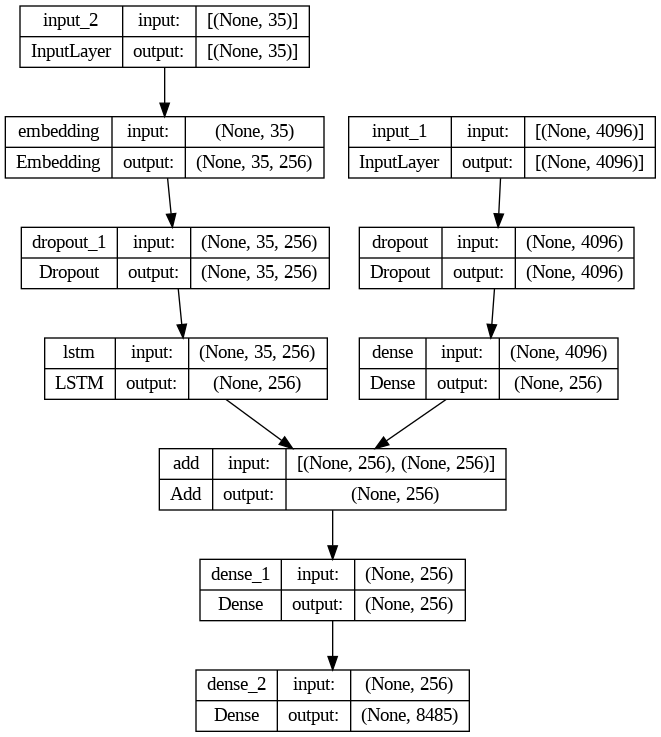

In [ ]:
# encoder model
# image feature layer
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layer
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


#decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)


In [ ]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 66s 291ms/step - loss: 2.2059


In [ ]:
#Save the model
m = model.save(WORKING_DIR+'/workingModel_001.keras')

In [ ]:
#save the model in a pickl file

# store features in pickle
pickle.dump(model, open(os.path.join(WORKING_DIR, 'modelFlikr8k_01.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'modelFlikr8k_01.pkl'), 'rb') as f:
    model_saved = pickle.load(f)

##Generate Captions for the Image


In [ ]:
#Function to convert predicted integers by the model to words again
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


# generate caption for an image
def predict_caption(model_saved, image, tokenizer, max_length):
    # add start tag for generaation process
    in_text = 'startseq '
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad sequences
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model_saved.predict([image, sequence], verbose=0)
        #get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        #stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text+=" " + word
        # stop if we reach end tag
        if word == ' endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    #get actual caption
    captions= mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model_saved, features[key], tokenizer, max_length)
    #split ino words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    #append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calculate BLEU score
print("BLEU-1:%f"% corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2:%f"% corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [ ]:
# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    # Get actual captions for the current image
    actual_captions = mapping[key]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(model, features[key], tokenizer, max_length)

    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()

    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU score
print("BLEU-1 :  %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2 :  %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

In [ ]:
print("BLEU-1 : %f"% corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2 : %f"% corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3 : %f"% corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0.5, 0)))

BLEU-1 : 0.166667
BLEU-2 : 0.097590
BLEU-3 : 0.015139


###We use the BLEW score as a performance metric

##Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    #image_name = ""
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('-------------Actual------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model_saved, features[image_id], tokenizer, max_length)
    print('--------------Predicted---------------')
    plt.imshow(image)
    print(remove_extra_endseq(y_pred))

In [ ]:
import re

def remove_extra_endseq(output_str):
    # Replace multiple occurrences of 'endseq' with a single 'endseq'
    cleaned_output = re.sub(r'\bendseq\b(?:\s*endseq\b)+', 'endseq', output_str)
    return cleaned_output


-------------Actual------------
startseq child playing on rope net endseq
startseq little girl climbing on red roping endseq
startseq little girl in pink climbs rope bridge at the park endseq
startseq small child grips onto the red ropes at the playground endseq
startseq the small child climbs on red ropes on playground endseq
--------------Predicted---------------
startseq  small girl grips red rope endseq


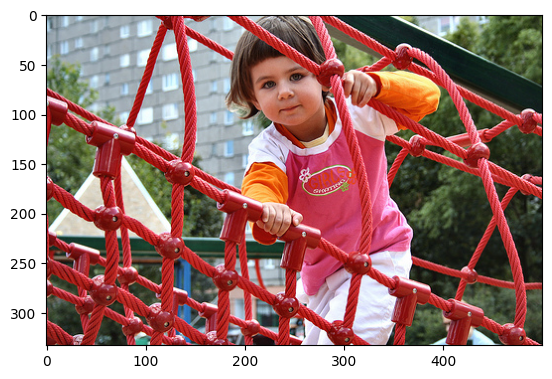

In [ ]:

#Calling the FUNCTION
generate_caption("1007320043_627395c3d8.jpg")


-------------Actual------------
startseq black and white dog is running in grassy garden surrounded by white fence endseq
startseq black and white dog is running through the grass endseq
startseq boston terrier is running in the grass endseq
startseq boston terrier is running on lush green grass in front of white fence endseq
startseq dog runs on the green grass near wooden fence endseq
--------------Predicted---------------
startseq  dog jumps over hurdle endseq


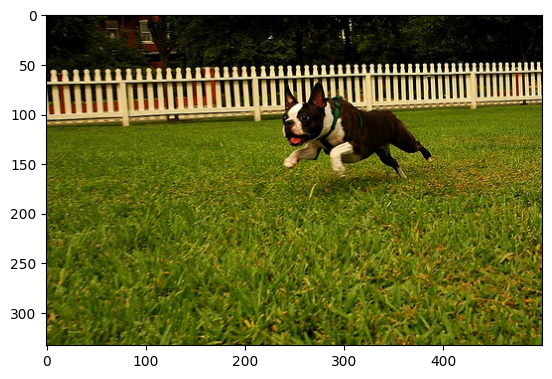

In [ ]:

#Calling the FUNCTION
generate_caption("1009434119_febe49276a.jpg")


-------------Actual------------
startseq two different breeds of brown and white dogs play on the beach endseq
startseq two dogs are making turn on soft sand beach endseq
startseq two dogs playing in the sand at the beach endseq
startseq two dogs playing together on beach endseq
startseq two large tan dogs play along sandy beach endseq
--------------Predicted---------------
startseq  two dogs are running along the beach endseq


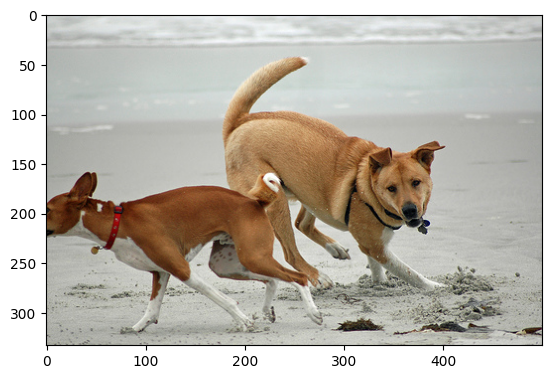

In [ ]:

#Calling the FUNCTION
generate_caption("1024138940_f1fefbdce1.jpg")


-------------Actual------------
startseq group of eight people are gathered around table at night endseq
startseq group of people gathered around in the dark endseq
startseq group of people sit around table outside on porch at night endseq
startseq group of people sit outdoors together at night endseq
startseq group of people sitting at table in darkened room endseq
--------------Predicted---------------
startseq  man in black shirt is changing the camera while sitting on porch endseq


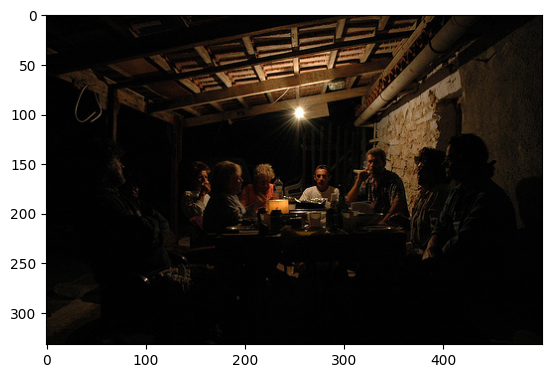

In [ ]:


#Calling the FUNCTION
generate_caption("107582366_d86f2d3347.jpg")


-------------Actual------------
startseq boy in blue shorts slides down slide into pool endseq
startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq
startseq boy rides down slide into small backyard pool endseq
startseq boy sliding down slide into pool with colorful tubes endseq
startseq child is falling off slide onto colored balloons floating on pool of water endseq
--------------Predicted---------------
startseq  boy in blue bathing suit slides into pool endseq in blue wading pool endseq


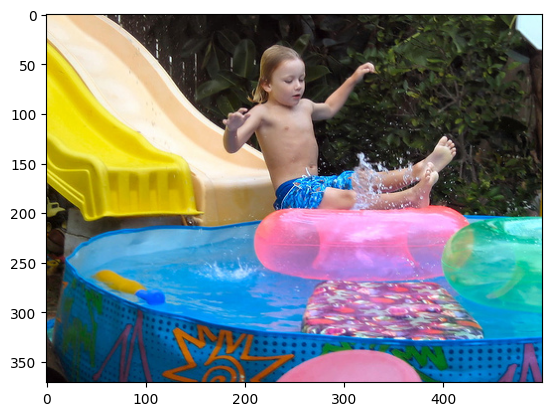

In [ ]:
#Calling the FUNCTION
generate_caption("1077546505_a4f6c4daa9.jpg")

-------------Actual------------
startseq man in pink shirt climbs rock face endseq
startseq man is rock climbing high in the air endseq
startseq person in red shirt climbing up rock face covered in assist handles endseq
startseq rock climber in red shirt endseq
startseq rock climber practices on rock climbing wall endseq
--------------Predicted---------------
startseq  man climbing rock wall endseq


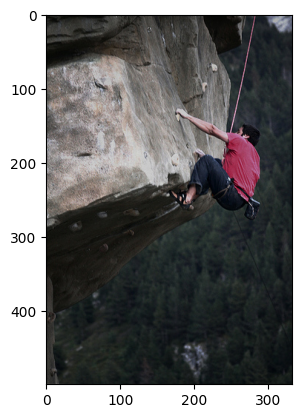

In [ ]:
#Calling the FUNCTION
generate_caption("997722733_0cb5439472.jpg")